In [1]:
import sys
import os

PROJ_ROOT = '/data/lry/code/style3d_gen'

sys.path.append(PROJ_ROOT)
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Test VAE (decoder only)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dict_keys(['data_id', 'surf_pos', 'latent', 'surf_cls', 'caption', 'item_idx']) 10169
*** latent size:  8
3878 52159 52171
torch.Size([12, 10]) torch.Size([12, 512]) torch.Size([12, 1]) dress, h-shape, raglan, raglan sleeves, no placket, waist darts, pieced waist, no hem, no collar, funnel neck
*** surf_latent:  torch.Size([12, 512]) tensor(-4.3602) tensor(5.2921) tensor(-0.0220) tensor(1.0232)
*** decoded:  torch.Size([12, 6, 256, 256]) tensor(-1.0712) tensor(1.0856)
torch.Size([6, 518, 2066]) tensor(0.) tensor(1.)


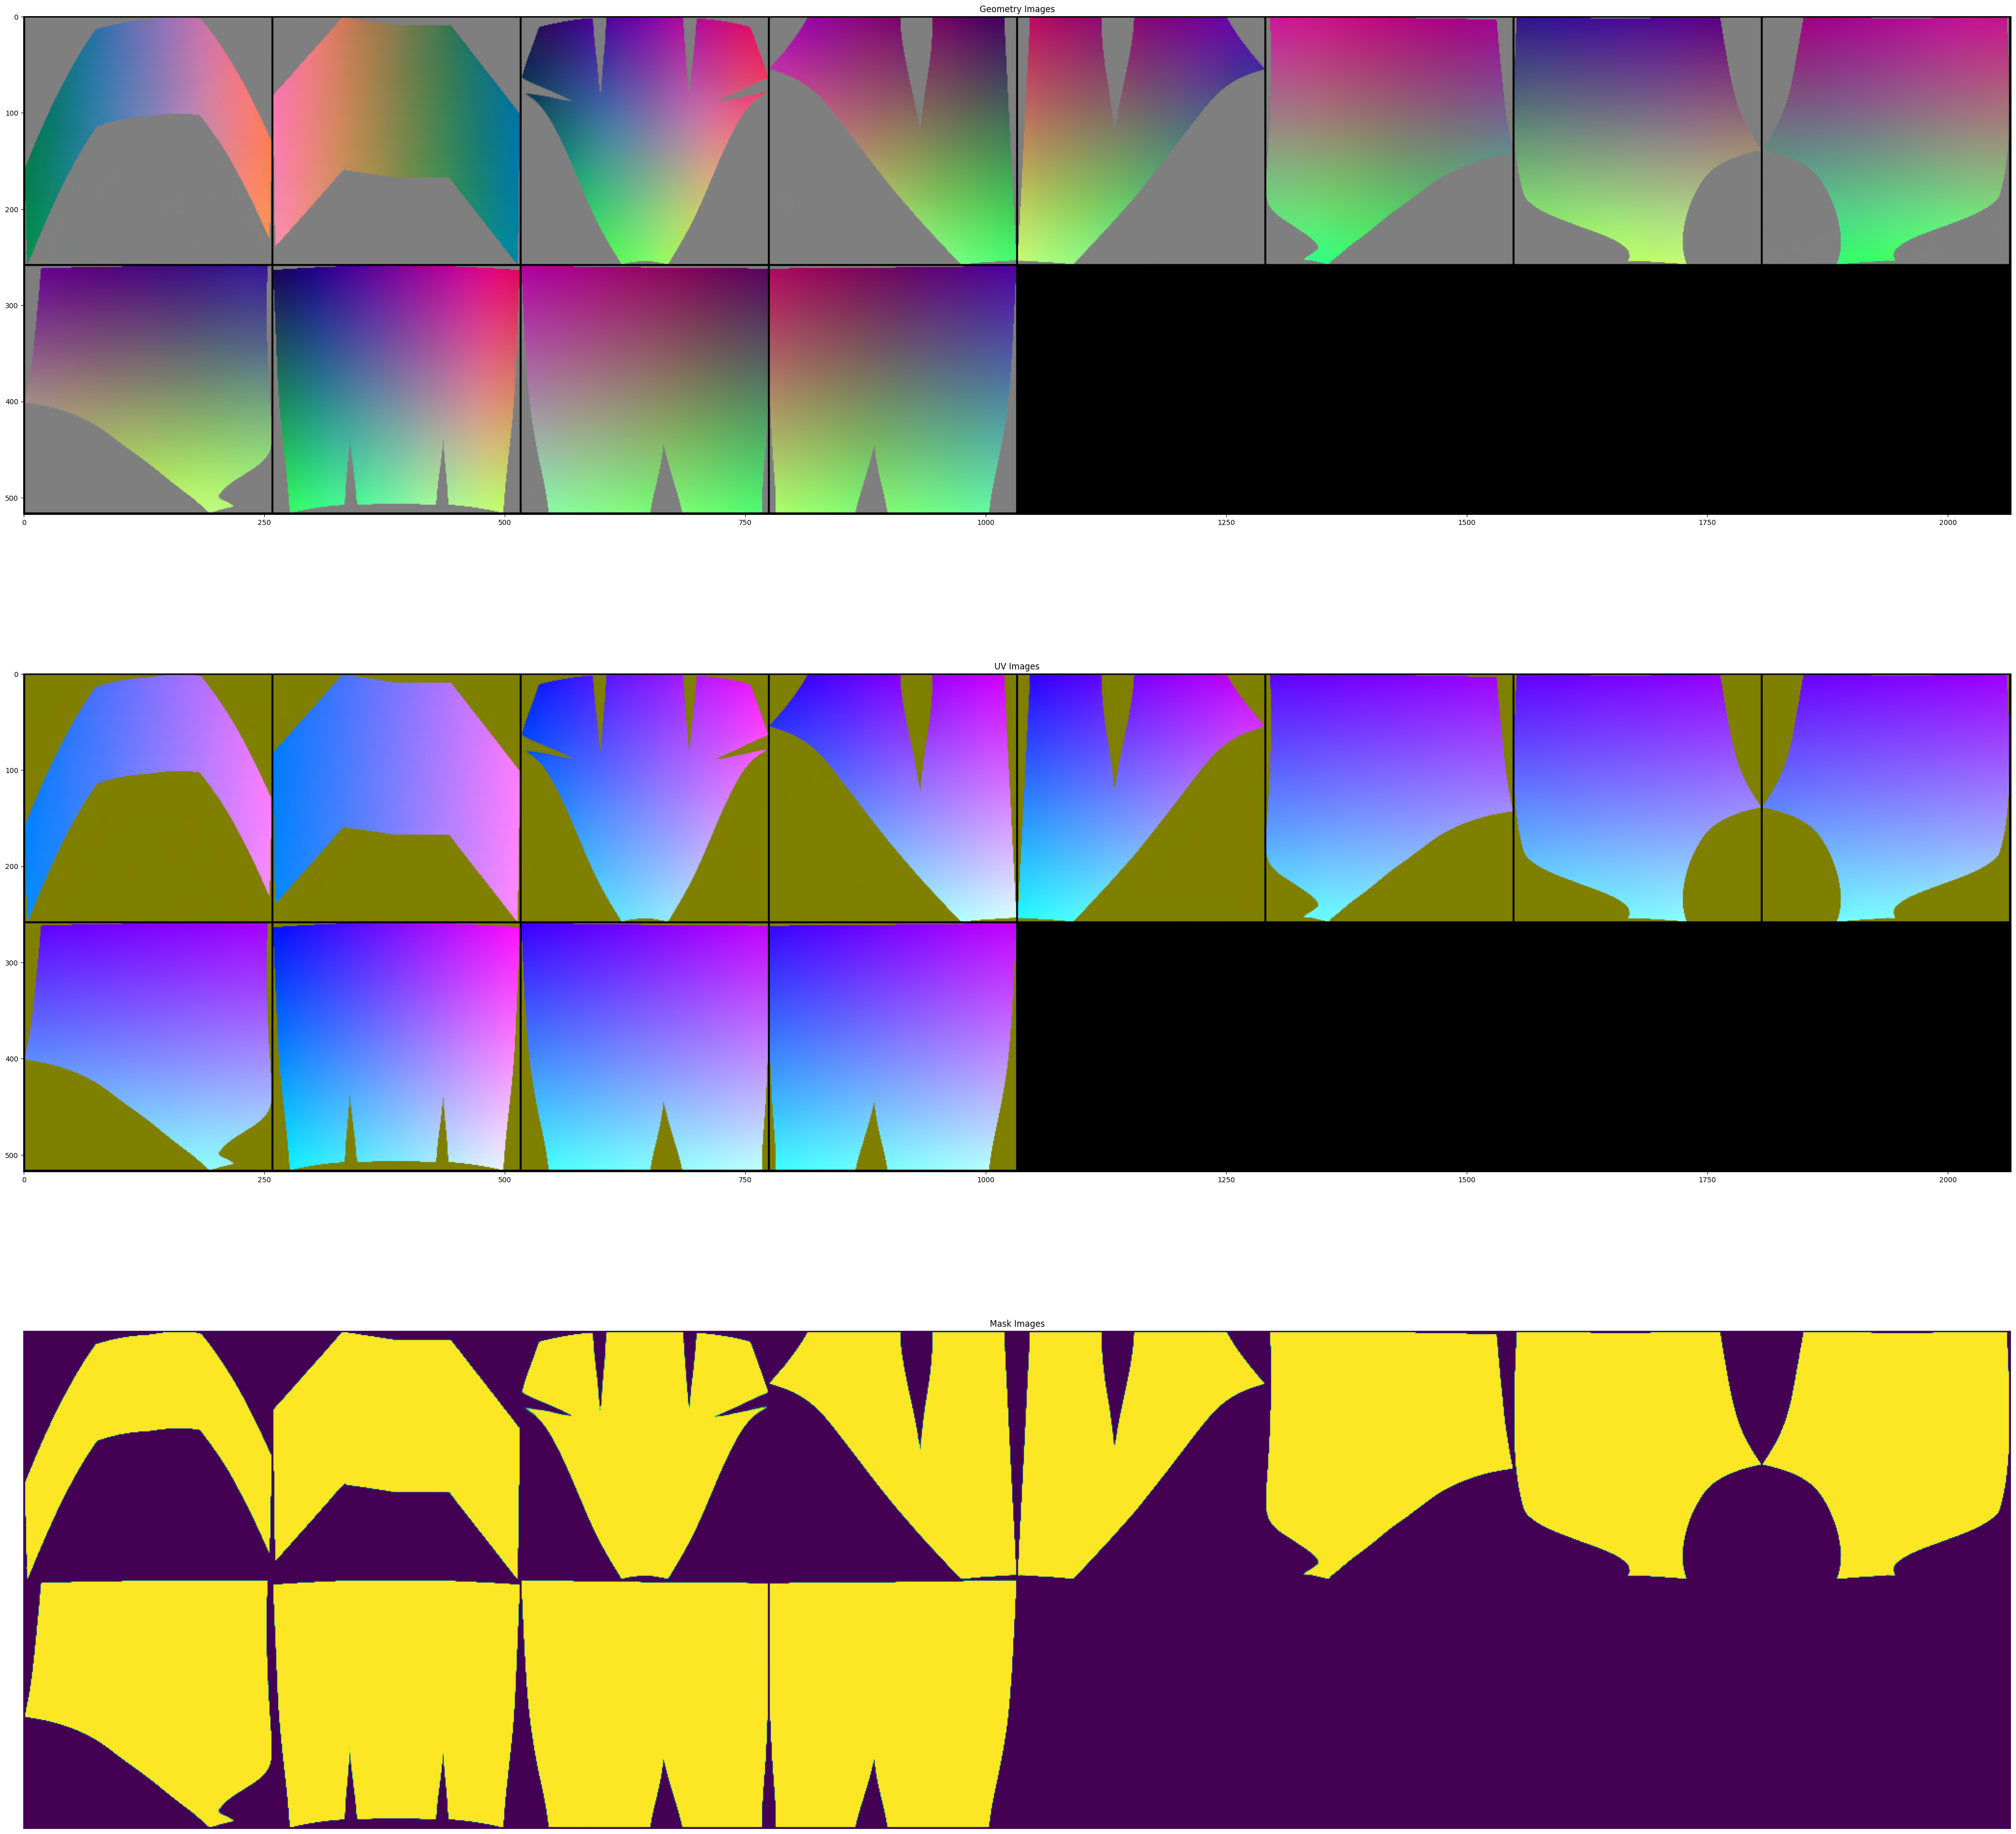

In [2]:
import torch
from network import AutoencoderKLFastDecode, AutoencoderKLFastEncode

import torch
from torchvision.utils import make_grid

from matplotlib import pyplot as plt

import random
import pickle

cache_fp = '/data/lry/code/style3d_gen/log/stylexd_vae_surf_256_xyz_uv_mask_unet6/cache/epoch_1800/surfz_train.pkl'
with open(cache_fp, 'rb') as f: data_cache = pickle.load(f)
print(data_cache.keys(), len(data_cache['item_idx']))

ckpt_fp = '/data/lry/code/style3d_gen/log/stylexd_vae_surf_256_xyz_uv_mask_unet6/ckpts/epoch_1800.pt'
block_dims = [16,32,32,64,64,128]
sample_size = 256
latent_channels = 8
latent_size = sample_size // 2**(len(block_dims)-1)
print('*** latent size: ', latent_size)

surf_vae_decoder = AutoencoderKLFastDecode( 
                                    in_channels=6,
                                    out_channels=6,
                                    down_block_types=['DownEncoderBlock2D']*len(block_dims),
                                    up_block_types=['UpDecoderBlock2D']*len(block_dims),
                                    block_out_channels=block_dims,
                                    layers_per_block=2,
                                    act_fn='silu',
                                    latent_channels=latent_channels,
                                    norm_num_groups=8,
                                    sample_size=sample_size
                                    )
surf_vae_decoder.load_state_dict(torch.load(ckpt_fp), strict=False)


sample_data_idx = random.randint(0, len(data_cache['item_idx']) - 1)
start_idx, end_idx = data_cache['item_idx'][sample_data_idx]

print(sample_data_idx, start_idx, end_idx)

surf_pos = data_cache['surf_pos'][start_idx:end_idx]
surf_latent = data_cache['latent'][start_idx:end_idx]
surf_cls = data_cache['surf_cls'][start_idx:end_idx]
caption = data_cache['caption'][sample_data_idx]

print(surf_pos.shape, surf_latent.shape, surf_cls.shape, caption)

print('*** surf_latent: ', surf_latent.shape, surf_latent.min(), surf_latent.max(), surf_latent.mean(), surf_latent.std())
with torch.no_grad():
    decoded_surf_pos = surf_vae_decoder(surf_latent.view(-1, latent_channels, latent_size, latent_size))
print('*** decoded: ', decoded_surf_pos.shape, decoded_surf_pos.min(), decoded_surf_pos.max())

pred_img = make_grid(decoded_surf_pos, nrow=8, normalize=True, value_range=(-1,1))
print(pred_img.shape, pred_img.min(), pred_img.max())

fig, ax = plt.subplots(3, 1, figsize=(40, 40))
ax[0].imshow(pred_img[:3, ...].permute(1, 2, 0).cpu().numpy())
ax[1].imshow(pred_img[3:, ...].permute(1, 2, 0).cpu().numpy())
ax[2].imshow(pred_img[-1:, ...].permute(1, 2, 0).cpu().numpy())

ax[0].set_title('Geometry Images')
ax[1].set_title('UV Images')
ax[2].set_title('Mask Images')

plt.tight_layout()
plt.axis('off')
plt.show()


# Test VAE with Encoder

*** latent size:  8  latent_channels:  8
/data/AIGP/brep_reso_256_edge_snap_with_caption/02285.pkl
*** caption:  dress, v-neck, puff sleeves, gathered, waist seam, a-line, skirt
*** latent:  torch.Size([18, 512]) tensor(-3.8446, device='cuda:0') tensor(3.7376, device='cuda:0') tensor(0.0334, device='cuda:0') tensor(0.9723, device='cuda:0')
*** decoded:  torch.Size([18, 6, 256, 256]) tensor(-1.0534, device='cuda:0') tensor(1.0481, device='cuda:0')
torch.Size([6, 776, 2066]) tensor(0., device='cuda:0') tensor(1., device='cuda:0')


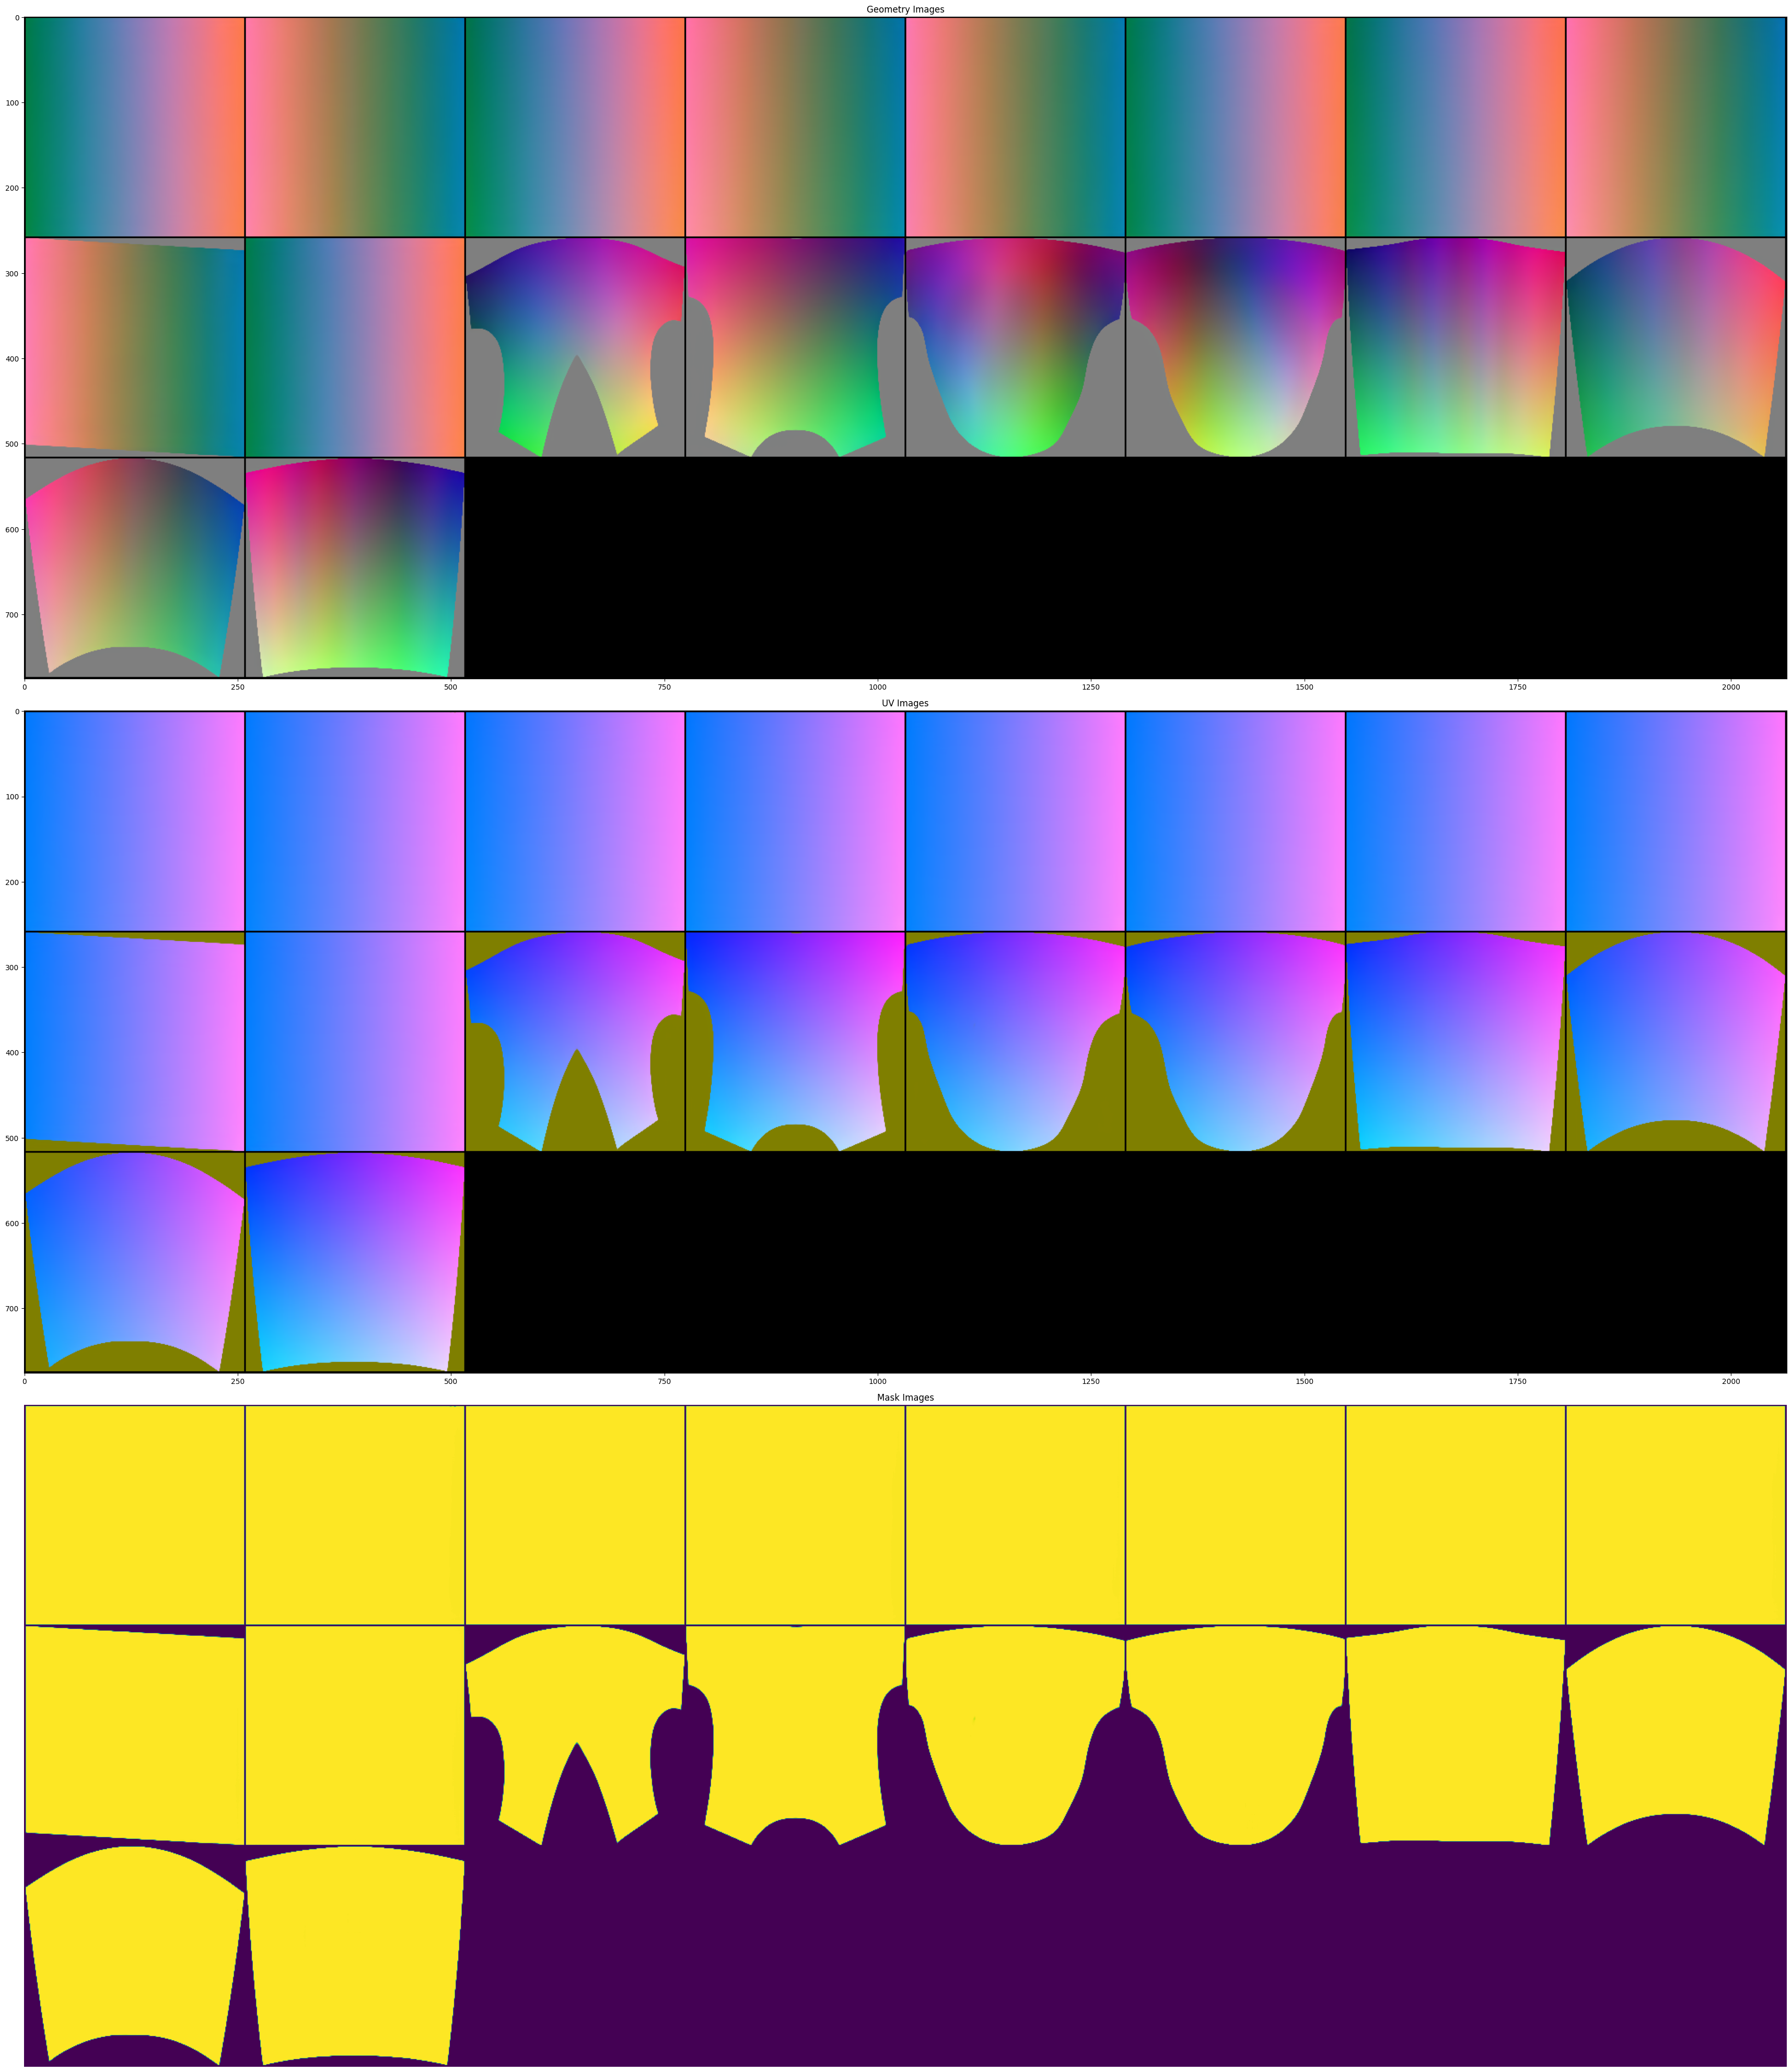

In [8]:
import numpy as np
import torch
from network import AutoencoderKLFastDecode, AutoencoderKLFastEncode

from glob import glob

import torch
from torchvision.utils import make_grid

from matplotlib import pyplot as plt

import random
import pickle

_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

ckpt_fp = '/data/lry/code/style3d_gen/log/stylexd_vae_surf_256_xyz_uv_mask_unet6/ckpts/epoch_1800.pt'
block_dims = [16,32,32,64,64,128]
sample_size = 256
latent_channels = 8
latent_size = sample_size // 2**(len(block_dims)-1)
print('*** latent size: ', latent_size, ' latent_channels: ', latent_channels)

################# Inintialize the encoder and decoder #################
surf_vae_encoder = AutoencoderKLFastEncode( 
                                    in_channels=6,
                                    out_channels=6,
                                    down_block_types=['DownEncoderBlock2D']*len(block_dims),
                                    up_block_types=['UpDecoderBlock2D']*len(block_dims),
                                    block_out_channels=block_dims,
                                    layers_per_block=2,
                                    act_fn='silu',
                                    latent_channels=latent_channels,
                                    norm_num_groups=8,
                                    sample_size=sample_size
                                    )
surf_vae_encoder.load_state_dict(torch.load(ckpt_fp), strict=False)
surf_vae_encoder.eval().to(_DEVICE)


surf_vae_decoder = AutoencoderKLFastDecode( 
                                    in_channels=6,
                                    out_channels=6,
                                    down_block_types=['DownEncoderBlock2D']*len(block_dims),
                                    up_block_types=['UpDecoderBlock2D']*len(block_dims),
                                    block_out_channels=block_dims,
                                    layers_per_block=2,
                                    act_fn='silu',
                                    latent_channels=latent_channels,
                                    norm_num_groups=8,
                                    sample_size=sample_size
                                    )
surf_vae_decoder.load_state_dict(torch.load(ckpt_fp), strict=False)
surf_vae_decoder.eval().to(_DEVICE)
########################################################################


data_root = '/data/AIGP/brep_reso_256_edge_snap_with_caption'
data_fp = random.choice(glob(os.path.join(data_root, '*.pkl')))
print(data_fp)

with open(data_fp, 'rb') as f: data = pickle.load(f)
surf_ncs = torch.FloatTensor(np.concatenate([
    data['surf_ncs'].astype(np.float32),
    data['surf_uv_ncs'].astype(np.float32),
    data['surf_mask'].astype(np.float32)*2.0-1.0
], axis=-1)).to(_DEVICE)

print('*** caption: ', data['caption'])

with torch.no_grad():
    latent = surf_vae_encoder(surf_ncs.permute(0, 3, 1, 2)).flatten(start_dim=1)
    print('*** latent: ', latent.shape, latent.min(), latent.max(), latent.mean(), latent.std())
    decoded_surf_ncs = surf_vae_decoder(latent.view(-1, latent_channels, latent_size, latent_size))
    print('*** decoded: ', decoded_surf_ncs.shape, decoded_surf_ncs.min(), decoded_surf_ncs.max())

pred_img = make_grid(decoded_surf_ncs, nrow=8, normalize=True, value_range=(-1,1))
print(pred_img.shape, pred_img.min(), pred_img.max())

fig, ax = plt.subplots(3, 1, figsize=(40, 40))
ax[0].imshow(pred_img[:3, ...].permute(1, 2, 0).cpu().numpy())
ax[1].imshow(pred_img[3:, ...].permute(1, 2, 0).cpu().numpy())
ax[2].imshow(pred_img[-1:, ...].permute(1, 2, 0).cpu().numpy())

ax[0].set_title('Geometry Images')
ax[1].set_title('UV Images')
ax[2].set_title('Mask Images')

plt.tight_layout()
plt.axis('off')
plt.show()


# Test VAE && SurfZ

dict_keys(['data_id', 'surf_pos', 'latent', 'surf_cls', 'caption', 'item_idx'])


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


175 2292 2308
torch.Size([16, 10]) torch.Size([16, 512]) torch.Size([16, 1]) dress, a-line shape, regular shoulder, one-piece sleeve, no placket, armhole princess seam, pieced waistline, high-low hem, collarless, trapezoid neckline
*** surf_latent:  torch.Size([16, 512]) tensor(-3.6523) tensor(4.2792) tensor(1.0035)
*** surf_pos torch.Size([1, 32, 10]) tensor(-1.3026) tensor(0.5745)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 77.40it/s]


*** surf_z torch.Size([16, 512]) tensor(-3.8401, grad_fn=<MinBackward1>) tensor(3.3341, grad_fn=<MaxBackward1>) tensor(-0.0045, grad_fn=<MeanBackward0>) tensor(0.9930, grad_fn=<StdBackward0>)
torch.Size([16, 6, 256, 256]) tensor(-1.1742) tensor(1.3626)
torch.Size([6, 776, 1550]) tensor(0.) tensor(1.)


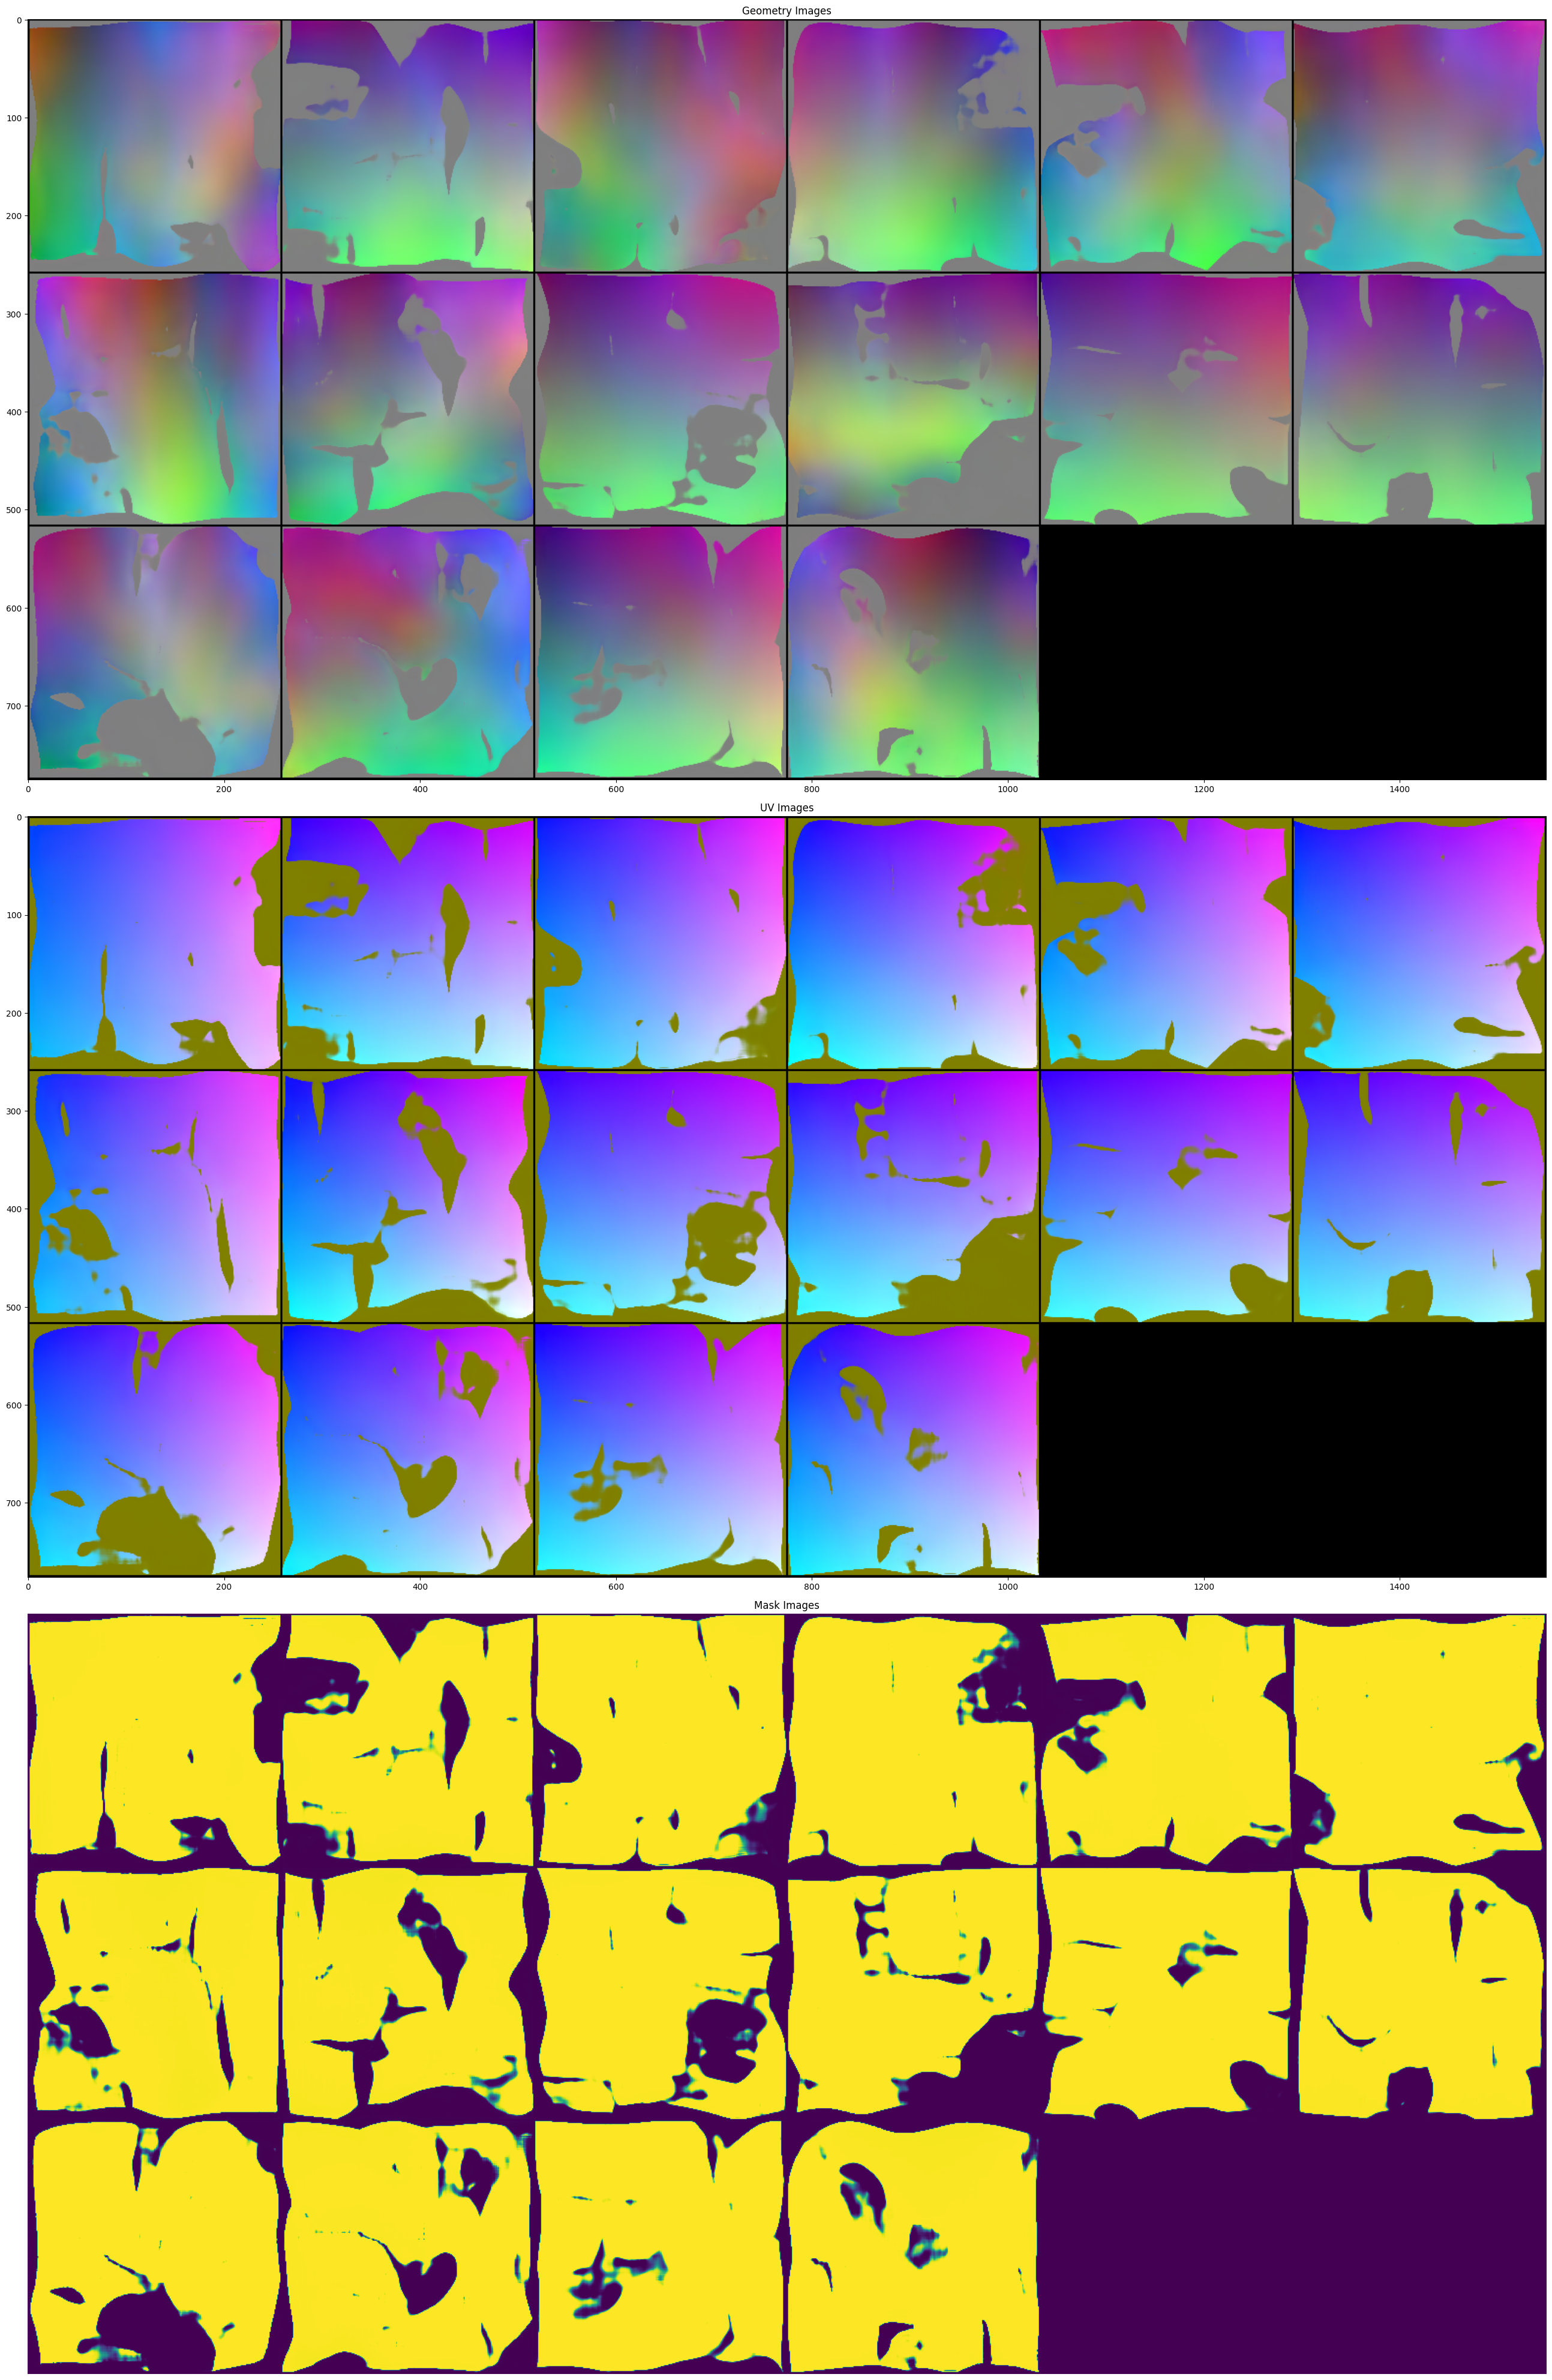

In [ ]:
import random
import pickle

from tqdm import tqdm

import torch
from torchvision.utils import make_grid

from network import AutoencoderKLFastDecode, SurfZNet
from diffusers import DDPMScheduler, PNDMScheduler
from utils import randn_tensor

from matplotlib import pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


cache_fp = '/data/lry/code/style3d_gen/log/stylexd_vae_surf_256_xyz_uv_mask_unet6/cache/epoch_1800/surfz_validate.pkl'
with open(cache_fp, 'rb') as f: data_cache = pickle.load(f)
print(data_cache.keys())

ckpt_fp = '/data/lry/code/style3d_gen/log/stylexd_vae_surf_256_xyz_uv_mask_unet6/ckpts/epoch_1800.pt'
# ckpt_fp = '/data/lry/code/dy/checkpoint/6G/ldm/surfz10200.pt'
block_dims = [16,32,32,64,64,128]
sample_size = 256

surf_vae = AutoencoderKLFastDecode( in_channels=6,
                                    out_channels=6,
                                    down_block_types=['DownEncoderBlock2D']*len(block_dims),
                                    up_block_types=['UpDecoderBlock2D']*len(block_dims),
                                    block_out_channels=block_dims,
                                    layers_per_block=2,
                                    act_fn='silu',
                                    latent_channels=8,
                                    norm_num_groups=8,
                                    sample_size=sample_size
                                    )
surf_vae.load_state_dict(torch.load(ckpt_fp), strict=False)
surf_vae.eval()

pndm_scheduler = PNDMScheduler(
    num_train_timesteps=1000,
    beta_schedule='linear',
    prediction_type='epsilon',
    beta_start=0.0001,
    beta_end=0.02,
)

ddpm_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule='linear',
    prediction_type='epsilon',
    beta_start=0.0001,
    beta_end=0.02,
    clip_sample=False,
)

# Load SurfZ Net
surfz_model_fp = '/data/lry/code/style3d_gen/log/stylexd_surfz_xyzuv_pad_zero_z_scale_1.0/ckpts/surfz_e7000.pt'
surfz_model = SurfZNet(p_dim=10, z_dim=512, num_heads=12, num_cf=-1)
surfz_model.load_state_dict(torch.load(surfz_model_fp)['model_state_dict'])
surfz_model.eval()

sample_data_idx = random.randint(0, len(data_cache['item_idx']) - 1)
start_idx, end_idx = data_cache['item_idx'][sample_data_idx]

print(sample_data_idx, start_idx, end_idx)

surf_pos = data_cache['surf_pos'][start_idx:end_idx]
surf_latent = data_cache['latent'][start_idx:end_idx]
surf_cls = data_cache['surf_cls'][start_idx:end_idx]
caption = data_cache['caption'][sample_data_idx]
print(surf_pos.shape, surf_latent.shape, surf_cls.shape, caption)

print('*** surf_latent: ', surf_latent.shape, surf_latent.min(), surf_latent.max(), surf_latent.std())

n_surfs, n_pads = surf_pos.shape[0], 32-surf_pos.shape[0]
# # pad zero
pad_idx = torch.randperm(n_surfs)
_surf_mask = torch.cat([
    torch.zeros(n_surfs, dtype=bool), torch.ones(n_pads, dtype=bool)
], dim=0)[None, ...]
_surf_pos = torch.cat([
    surf_pos[pad_idx, ...], torch.zeros((n_pads, *surf_pos.shape[1:]), dtype=surf_pos.dtype, device=surf_pos.device)
], dim=0)[None, ...]
print('*** surf_pos', _surf_pos.shape, _surf_pos.min(), _surf_pos.max())

# Diffusion Generation
surfZ = randn_tensor((1, 32, 8*8*8))
ddpm_scheduler.set_timesteps(1000)
for t in tqdm(ddpm_scheduler.timesteps):
    timesteps = t.reshape(-1)
    pred = surfz_model(surfZ, timesteps, _surf_pos, _surf_mask, None)
    _surf_z = ddpm_scheduler.step(pred, t, surfZ).prev_sample
    
_surf_z = _surf_z.squeeze(0)[~_surf_mask.squeeze(0), ...]
print('*** surf_z', _surf_z.shape, _surf_z.min(), _surf_z.max(), _surf_z.mean(), _surf_z.std())

# VAE Decoding
with torch.no_grad(): decoded_surf_pos = surf_vae(_surf_z.view(-1, 8, 8, 8))
print(decoded_surf_pos.shape, decoded_surf_pos.min(), decoded_surf_pos.max())

pred_img = make_grid(decoded_surf_pos, nrow=6, normalize=True, value_range=(-1,1))
print(pred_img.shape, pred_img.min(), pred_img.max())

fig, ax = plt.subplots(3, 1, figsize=(40, 40))
ax[0].imshow(pred_img[:3, ...].permute(1, 2, 0).detach().cpu().numpy())
ax[1].imshow(pred_img[3:, ...].permute(1, 2, 0).detach().cpu().numpy())
ax[2].imshow(pred_img[-1:, ...].permute(1, 2, 0).detach().cpu().numpy())

ax[0].set_title('Geometry Images')
ax[1].set_title('UV Images')
ax[2].set_title('Mask Images')

plt.tight_layout()
plt.axis('off')

# plt.savefig('decoded_surf.png', transparent=True, dpi=72)
plt.show()
